# Logistic Regression baseline


## Import the tools we need
* **pandas / numpy** – handle data tables and math
* **scikit‑learn** – train/test split, scaling, logistic regression, and model metrics
* **matplotlib** – make simple charts


In [82]:
# import basic data tools and the ML functions we need
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


## Load Griffin's cleaned data

In [83]:
# read Griffin's cleaned CSV
df = pd.read_csv("data/spotify_80s_clean.csv")  # dropped `track`, `artist`, and `uri`
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,0.509,0.277,6,-14.323,1,0.0495,0.827000,0.002060,0.0756,0.640,101.157,161893,4,68.46530,7,0
1,0.716,0.753,2,-5.682,1,0.0286,0.162000,0.030600,0.0831,0.561,120.141,222000,4,57.71583,11,1
2,0.360,0.542,5,-13.885,1,0.0339,0.368000,0.165000,0.1160,0.803,116.831,444907,4,30.34574,17,0
3,0.656,0.512,7,-11.872,1,0.0290,0.585000,0.000000,0.0720,0.880,97.500,157893,3,50.97022,7,0
4,0.642,0.889,2,-5.620,0,0.0494,0.375000,0.000000,0.1800,0.764,163.351,162293,4,33.62053,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6903,0.443,0.589,7,-8.085,1,0.0392,0.552000,0.000000,0.1410,0.963,97.401,384360,4,31.61135,23,0
6904,0.208,0.750,9,-12.945,1,0.1080,0.000134,0.000002,0.0621,0.394,83.467,154827,4,23.71780,8,0
6905,0.739,0.729,4,-9.694,0,0.0572,0.249000,0.007680,0.0690,0.884,103.339,375652,4,31.31730,13,1
6906,0.749,0.626,0,-12.426,1,0.0393,0.011500,0.567000,0.0558,0.770,142.565,366133,4,27.71571,18,1


##   Split features ( X ) and label ( y )
* **X** = audio numbers we will feed into the model
* **y** = `target` column (1 = hit, 0 = flop)

In [84]:
# separate inputs (X) from the answer we want to predict (y)
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


##### Create train and test sets
We keep 75% of the songs for training and 25 % for testing.
`stratify=y` keeps the hit/flop ratio the same in both sets.
`random_state=42` makes the split reproducible.

##   Build a modeling pipeline
1. **StandardScaler** – puts every feature on the same scale (mean 0, std 1).
2. **LogisticRegression** – learns weights that turn features into a hit‑probability.
`class_weight="balanced"` tells the model to treat hits and flops equally even if counts differ.

In [85]:
# pipeline = scale data  ➜  run logistic regression
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

##   Train the model
The model looks at the training songs and learns which features push a track toward “hit” or “flop.”

In [86]:
# train the model on the training data
model = logreg_pipe.fit(X_train, y_train)

##   Check how well the model works on new (test) songs
We print four common scores and draw a confusion matrix.
Higher **F1** means better balance between precision and recall.

Accuracy : 0.760
Precision: 0.723
Recall   : 0.841
F1 Score : 0.778


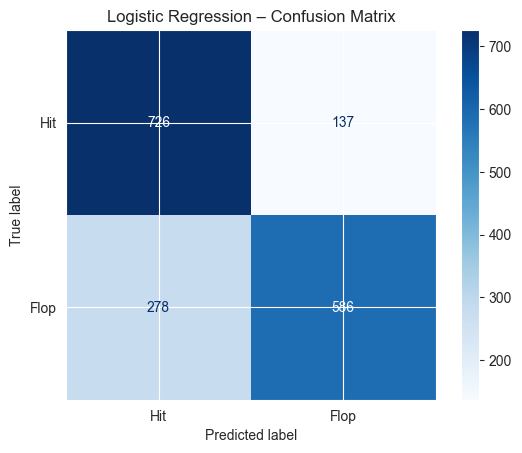

In [87]:
y_pred = model.predict(X_test)

print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred, labels=[1,0])
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=["Hit","Flop"]).plot(cmap="Blues")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

### What those counts tell us
* Hits the model got right: 726 songs that really were hits were labeled “Hit.” Good—these boost recall.

* Hits it missed: 137 real hits were called “Flop.” These hurt recall; about 16 % of hits are still slipping through.

* False alarms: 278 flops were predicted as hits. These lower precision; listeners would get some “flops” in a recommended‑hits list.

* Flops correctly rejected: 586 flops were labeled “Flop.” Good—these keep the recommendations cleaner.

## Find the most influential audio features
Positive weight  →  pushes a song toward **hit**.
Negative weight  →  pushes a song toward **flop**.

In [88]:
# turn coefficient array into a neat table
coefs = pd.Series(
    model.named_steps["clf"].coef_[0],
    index=X.columns
).sort_values(key=np.abs, ascending=False)

print("Top 10 most influential features:")
for feat, weight in coefs.head(10).items():
    direction = "↑ hit‑probability" if weight > 0 else "↓ hit‑probability"
    print(f"{feat:<20s} {weight:>8.3f}   {direction}")

Top 10 most influential features:
instrumentalness       -1.240   ↓ hit‑probability
speechiness            -0.978   ↓ hit‑probability
danceability            0.828   ↑ hit‑probability
acousticness           -0.642   ↓ hit‑probability
loudness                0.496   ↑ hit‑probability
duration_ms             0.256   ↑ hit‑probability
energy                 -0.207   ↓ hit‑probability
tempo                   0.184   ↑ hit‑probability
sections               -0.179   ↓ hit‑probability
liveness               -0.164   ↓ hit‑probability


**How to read this**

* A **positive weight** means the feature raises the song’s hit probability.
  *Example: higher **danceability** and **loudness** push a track toward “Hit.”*

* A **negative weight** means the feature lowers the hit probability.
  *Example: songs that are highly **instrumental** or heavy on **speech** lean “Flop.”*

* The **bigger the absolute value**, the stronger the influence.
  *Instrumentalness (‑1.24) has the strongest single impact in this model.*

In [89]:
top10_df = coefs.head(10).reset_index()
top10_df.columns = ["feature", "coefficient"]
try:
    display(top10_df)          # interactive table
except Exception:
    print(top10_df.to_string()) # plain text fallback


,feature,coefficient
0,instrumentalness,-1.240171
1,speechiness,-0.978266
2,danceability,0.828222
3,acousticness,-0.642057
4,loudness,0.496035
5,duration_ms,0.256174
6,energy,-0.206789
7,tempo,0.183667
8,sections,-0.178514
9,liveness,-0.164066


### Save the trained model and results



In [90]:
import joblib, pathlib, json

pathlib.Path("models").mkdir(exist_ok=True)
joblib.dump(model, "models/log_reg_baseline.pkl")
coefs.to_csv("models/log_reg_coefficients.csv")